In [1]:
%matplotlib notebook
import h5py
from psana import DataSource
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import rotate

manta_peds = np.load('/reg/g/psdm/tutorials/ami2/neh2.2/manta_ped.npy')

ds = DataSource(exp='rixx43518', run=71, dir='/reg/data/ana03/rix/rixx43518/xtc')#, max_events=100)
myrun = next(ds.runs())

manta = myrun.Detector('manta')
# Note: to check object attributes dir('manta')

# rotatin angle in degrees
rot = -0.5

# ROI
# run 45
x0, x1 = 0, 750
y0, y1 = 900, 1000
#run 49
x0, x1 = 0, 900
y0, y1 = 800, 1350
#run 61,71
x0, x1 = 0, 1500
y0, y1 = 700, 1000
epics_det = myrun.Detector('step_value')
imgsum = np.zeros((2048, 2048))

step = []
img_all = []
proj_all = []
nevents = 0
#img_all = np.zeros((2048,2048,nevents))
for evt in myrun.events():
    img0 = manta.raw.value(evt)
    if img0 is None: continue
        
    img1 = img0 - manta_peds
    img = rotate(img1, rot, reshape=False)
    
    step_val = epics_det(evt)
    
    #print(img.shape)
    imgsum += img
    nevents += 1
    step = np.append(step,step_val)
    #img_all = np.append(img_all,img)
    proj_all = np.append(proj_all,np.sum(img[x0:x1, y0:y1], axis=0))
    # check for missing data
    #print(img.shape,epics_val)
    #if img is None or epics_val is None:
    #    print('none')
    #    continue
    #print(img.shape,epics_val)

print(np.shape(proj_all))
#img_all = np.reshape(img_all, (2048, 2048, -1))
#proj_all = np.reshape(proj_all, (y1-y0, -1))
proj_all = np.reshape(proj_all, (-1, y1-y0))
proj_all = np.transpose(proj_all)
print(np.shape(proj_all))

(710400,)
(300, 2368)


In [6]:
import numpy as np
manta_peds = np.load('/reg/g/psdm/tutorials/ami2/neh2.2/manta_ped.npy')
np.shape(manta_peds)

(2048, 2048)

<IPython.core.display.Javascript object>


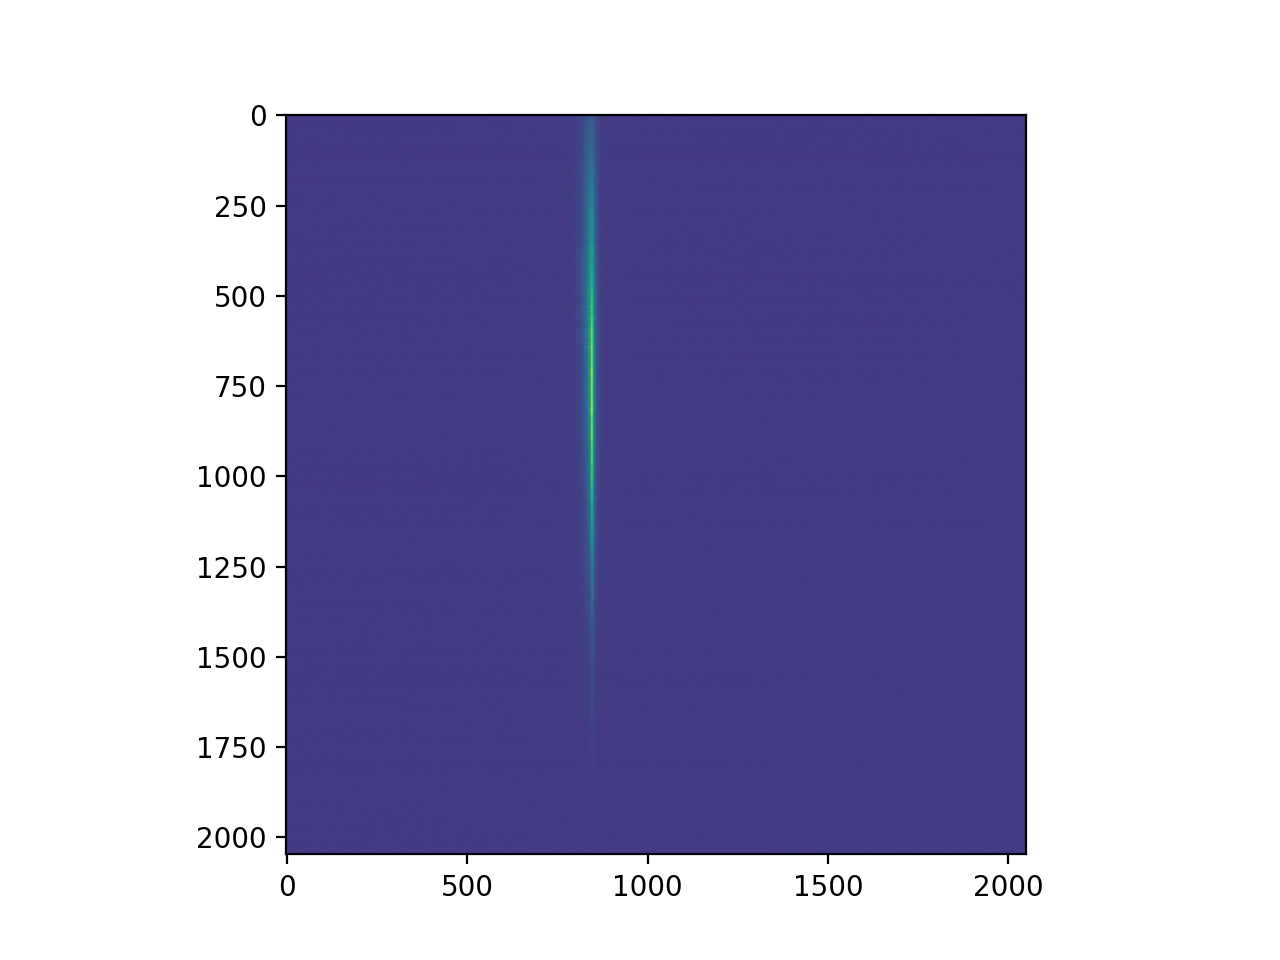

<IPython.core.display.Javascript object>


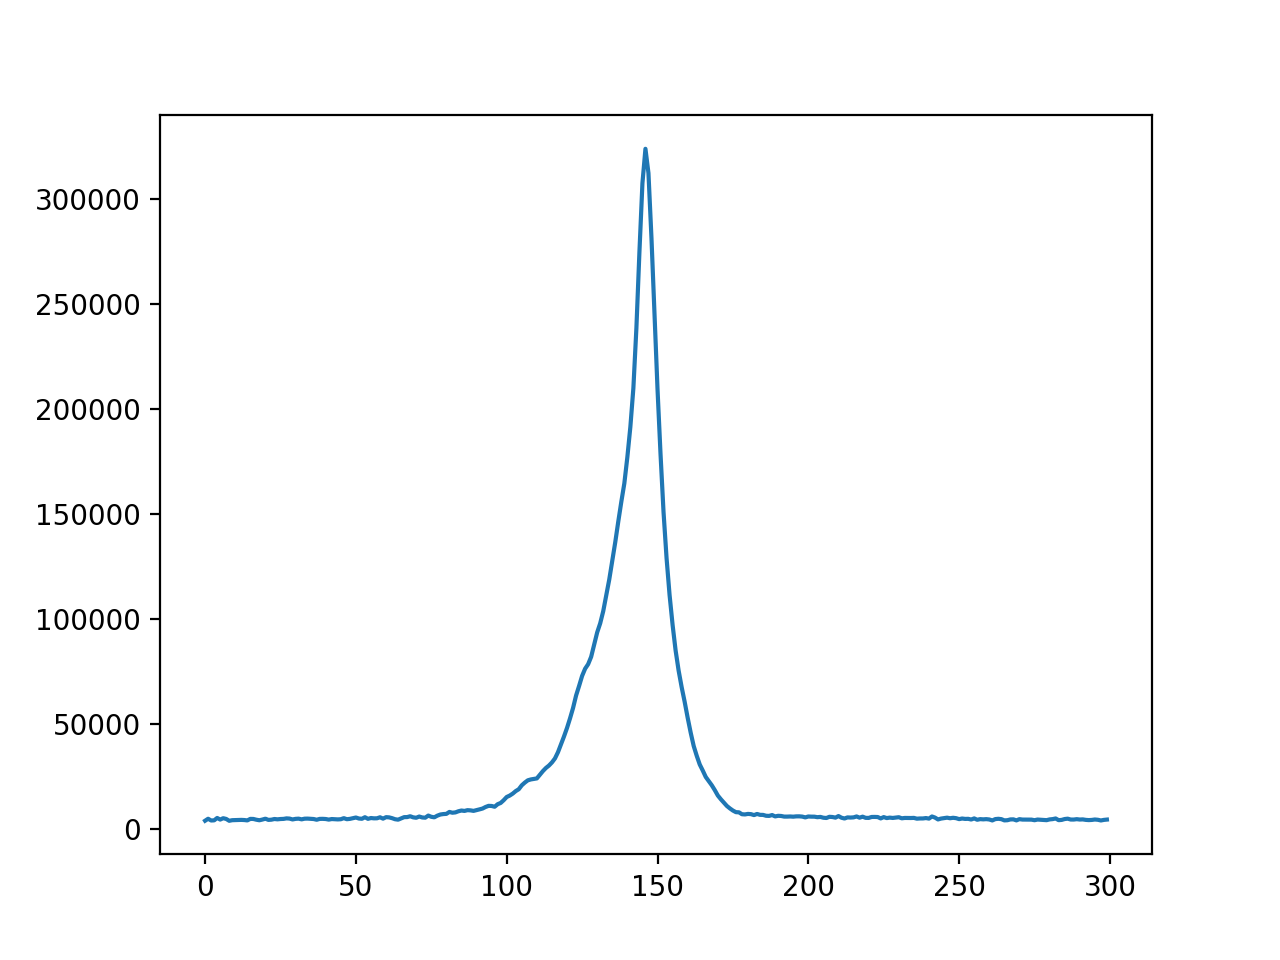

In [4]:
plt.figure()
plt.imshow(imgsum)

proj = np.mean(imgsum[x0:x1, y0:y1], axis=0)

plt.figure()
plt.plot(proj)

In [3]:
y = np.arange(y0,y1)
proj = np.sum(imgsum[x0:x1, y0:y1], axis=0)

step_u, ind0, ind = np.unique(step, return_index=True, return_inverse=True)

#img_u = np.zeros((2048,2048,len(step_u)))
#for shot in np.arange(len(step)):
#    img_u[:,:,ind[shot]] += img_all[:,:,shot]

threshold = 0#85000
#proj_u = np.sum(img_u[x0:x1, y0:y1,:]-threshold, axis=0)

proj_u = np.zeros((y1-y0,len(step_u)))
for shot in np.arange(nevents):
    proj_u[:,ind[shot]] += proj_all[:,shot]-threshold



<IPython.core.display.Javascript object>


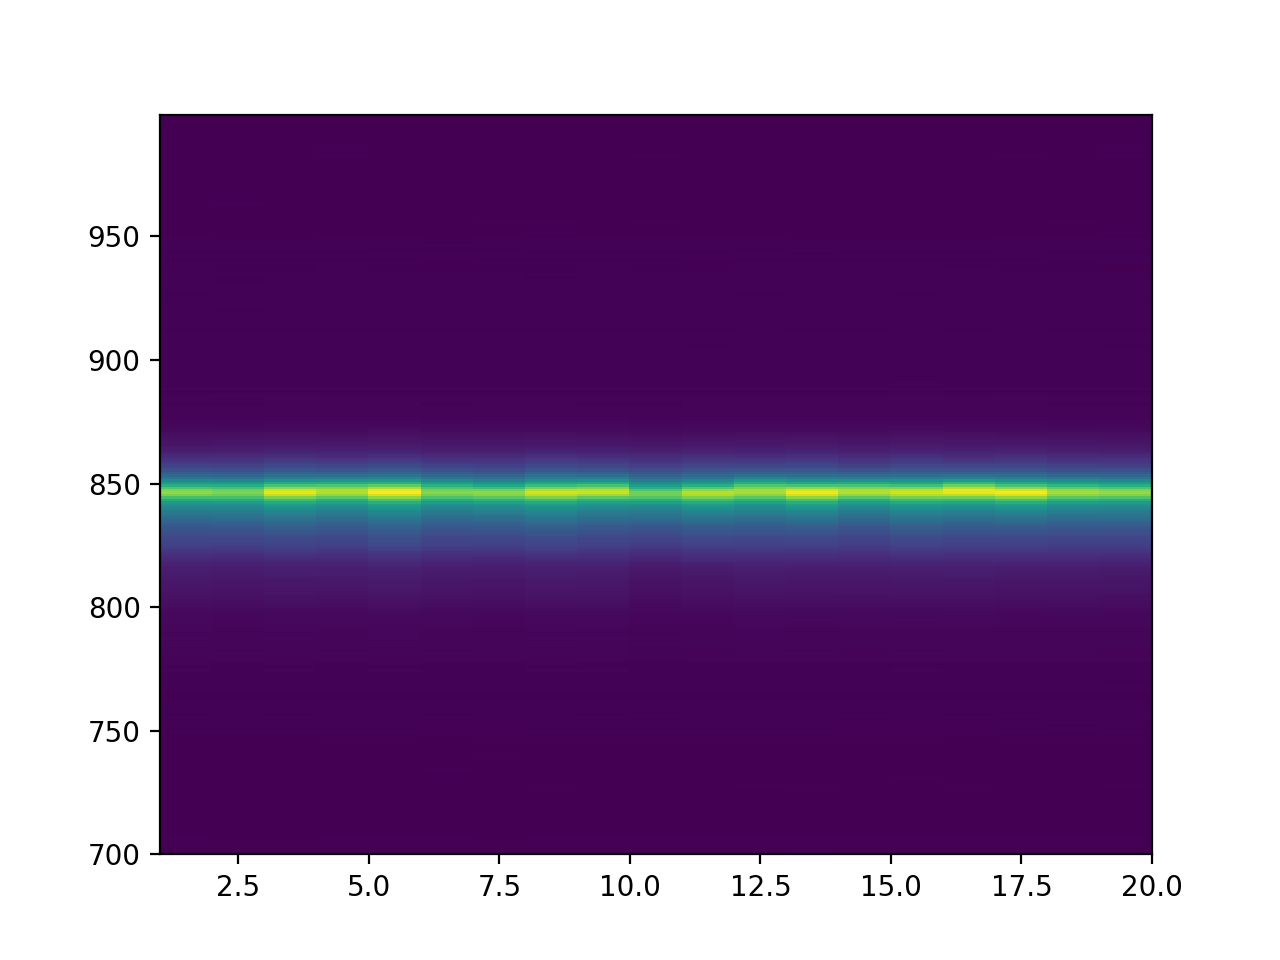

/cds/sw/ds/ana/conda2/inst/envs/ps-4.2.0/lib/python3.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


[2.77654601e+05 1.68676846e+07 8.44325727e+02 2.13156492e+01]
[2.53319759e+05 1.66283845e+07 8.44191707e+02 2.16323973e+01]
[3.16597073e+05 1.94369832e+07 8.44536478e+02 2.03027490e+01]
[3.09280100e+05 1.84768518e+07 8.44738596e+02 2.02583891e+01]
[3.34870280e+05 2.01995520e+07 8.44525795e+02 2.03161441e+01]
[2.69276383e+05 1.69135632e+07 8.44356374e+02 2.13142302e+01]
[2.60978330e+05 1.69537310e+07 8.43971460e+02 2.13198013e+01]
[3.01460544e+05 1.88696873e+07 8.44303967e+02 2.10138807e+01]
[3.17543676e+05 1.86547112e+07 8.44756803e+02 1.99437972e+01]
[2.29387350e+05 1.62789957e+07 8.43896153e+02 2.14538207e+01]
[2.66277294e+05 1.82614384e+07 8.44088964e+02 2.09626069e+01]
[2.99323684e+05 1.84387832e+07 8.44751254e+02 2.05275718e+01]
[3.17535698e+05 1.99522089e+07 8.44556613e+02 1.96936845e+01]
[3.16165191e+05 1.84999466e+07 8.44881236e+02 1.93797166e+01]
[3.00669633e+05 1.89496324e+07 8.44404963e+02 2.06559645e+01]
[3.52819540e+05 2.02482212e+07 8.45010905e+02 1.86707918e+01]
[3.17401

<IPython.core.display.Javascript object>


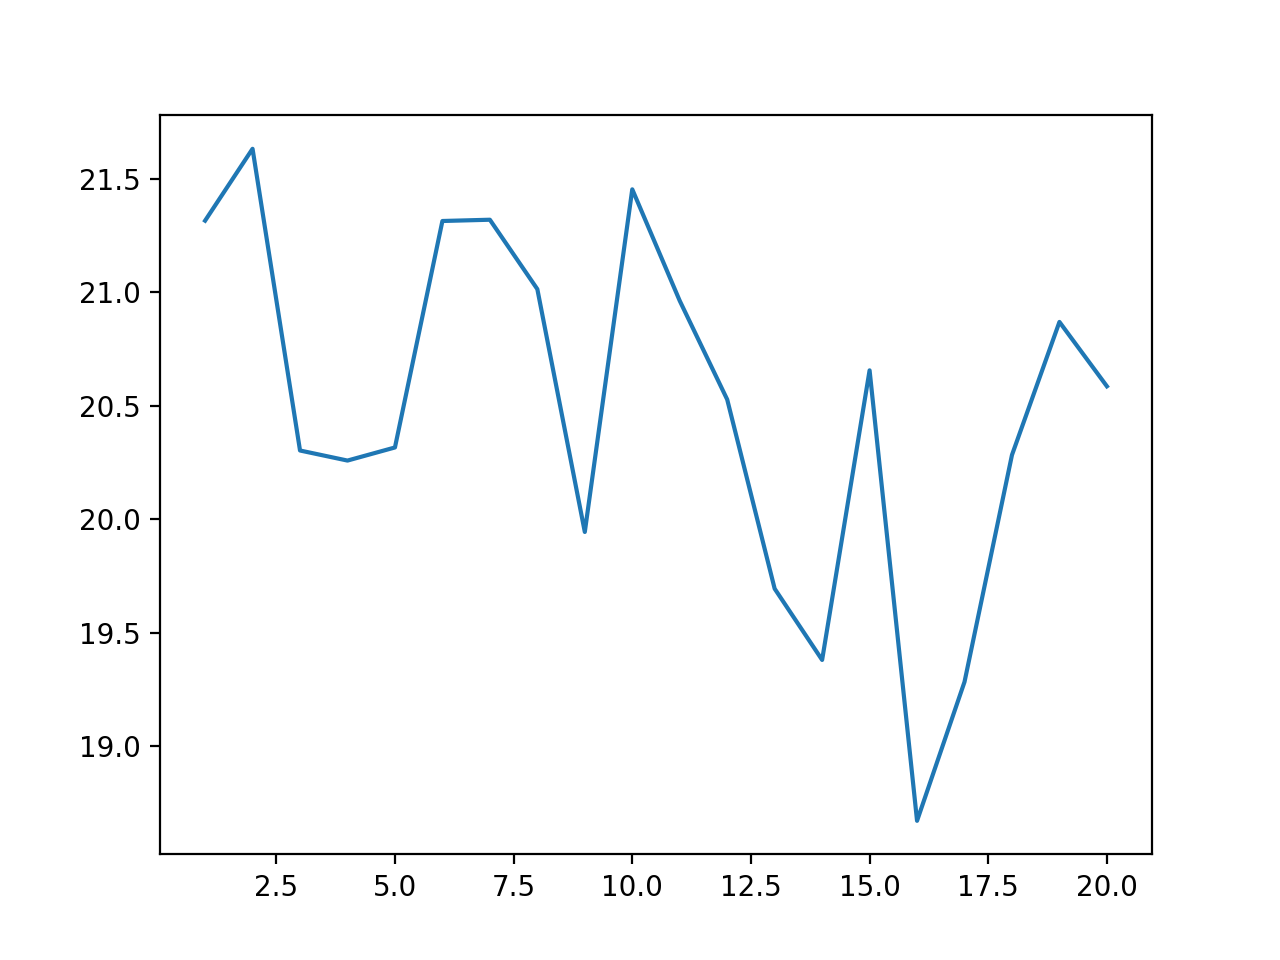

<IPython.core.display.Javascript object>


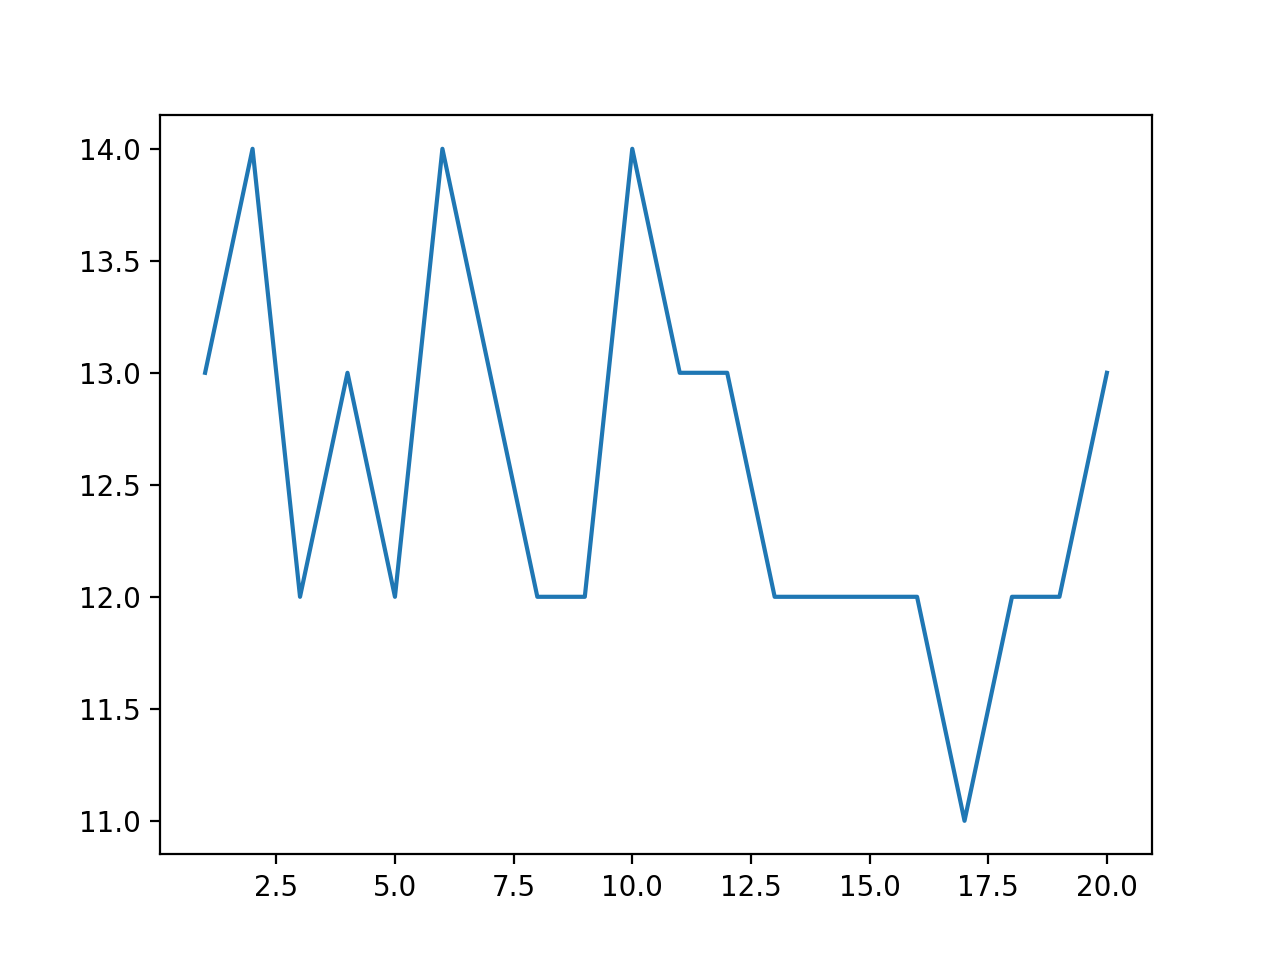

In [18]:

bckg = np.mean(proj_u[:20,:],axis=0)
proj_u = proj_u - bckg[None,:]


plt.figure()
plt.pcolormesh(step_u, y,proj_u)
#plt.pcolormesh(y, step_u, proj_u)
#plt.imshow(proj_u)

def get_peakparam2(x,y):
    ymax = np.amax(y)
    ipos = np.abs(y-ymax).argmin()
    xpos = x[ipos]
    area = np.sum(y)*(x[1]-x[0])
    ihalf1 = np.abs(y[:ipos]-0.5*ymax).argmin()
    ihalf2 = np.abs(y[ipos:]-0.5*ymax).argmin()
    Dx = x[ipos+ihalf2]-x[ihalf1]
    Dxr = x[ipos+ihalf2]-xpos
    Dxl = xpos-x[ihalf1] 
    return xpos,Dx,ymax,area,Dxl,Dxr

def model(x,a,A,pos,width):
    sigma = width/(2*np.sqrt(2*np.log(2)))
    y = a + A*np.exp(-(x-pos)**2/(2*sigma**2))
    return y

# run 45
pinit = (5.4e6,3e5,950,10.0)
bounds = ((5e6,1e5,925,10.0),(5.6e6,5e5,975,50.0))
# run 49
pinit = (1e7,6e6,1070,100.0)
# run 52
pinit = (1e6,3e6,1070,90.0)
# run 61
pinit = (4e8,3e8,900,90.0)
# run 71
bounds = ((0,0,y0,1.0),(np.inf,np.inf,y1,np.inf))
popt, pcov = curve_fit(model, y, proj, p0=pinit, bounds=bounds)


pos = np.zeros(len(step_u))
w = np.zeros(len(step_u))
fwhm = np.zeros(len(step_u))
fit_u = np.zeros((y1-y0,len(step_u)))
for i in np.arange(len(step_u)):
    #
    xpos,Dx,ymax,area,Dxl,Dxr = get_peakparam2(y, proj_u[:,i])
    fwhm[i] = Dx
    #
    pinit = (0,ymax,xpos,Dx)
    popt, pcov = curve_fit(model, y, proj_u[:,i], p0=pinit, bounds=bounds)
    fit = model(y,*popt)
    fit_u[:,i] = fit
    print(popt)
    pos[i] = popt[2] 
    w[i] = popt[3]
    
    
plt.figure()
plt.plot(step_u,w)

plt.figure()
plt.plot(step_u,fwhm)

In [192]:
np.abs(w-12).argmin()

16

<IPython.core.display.Javascript object>


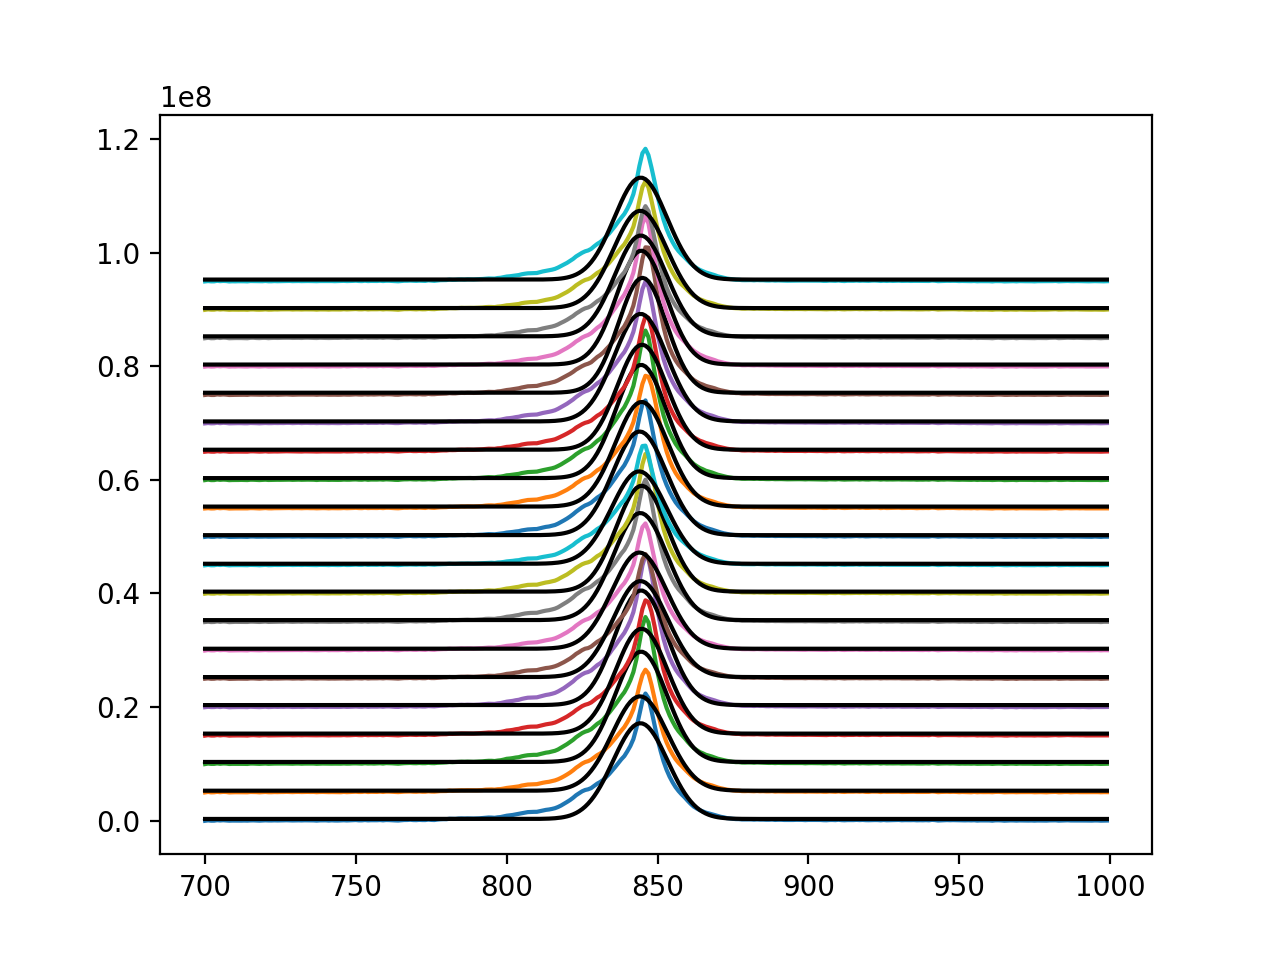

In [19]:
plt.figure()
#plt.plot(proj_u[:,1])
for i in np.arange(len(step_u)):
    plt.plot(y,proj_u[:,i]+i*0.5e7)
    plt.plot(y,fit_u[:,i]+i*0.5e7, 'k')

In [184]:
np.shape(proj_all)

(550, 3558)

<IPython.core.display.Javascript object>


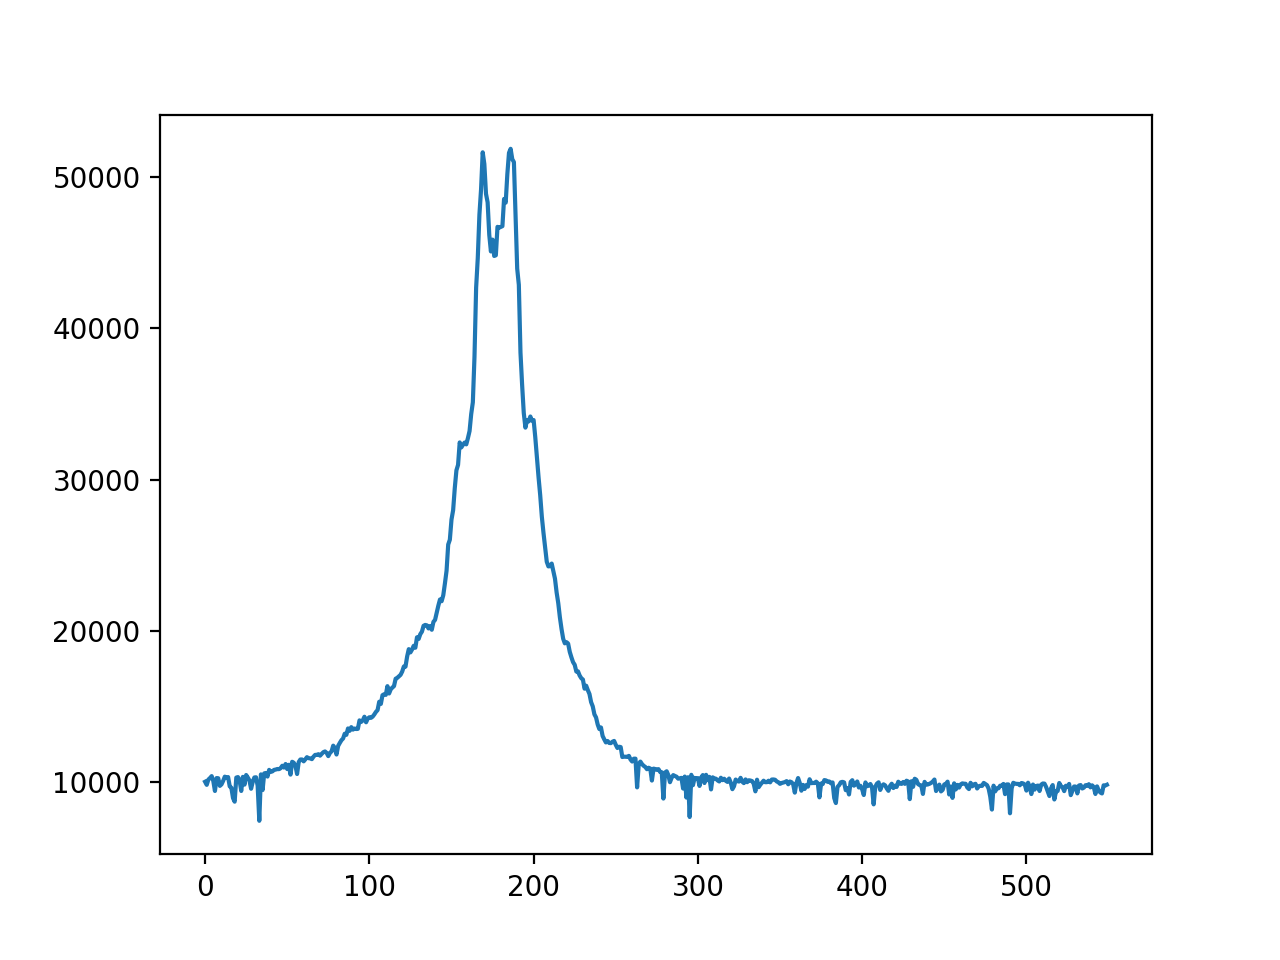

In [211]:
plt.figure()
plt.plot(proj_all[:,1609])